In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
from torch.functional import F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import Data, HeteroData
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.utils.convert import to_networkx
import networkx as nx

from sklearn.preprocessing import MinMaxScaler

In [28]:
# Load network data: node features, edge_features and edge_index
node_features = pd.read_csv('network/node_features.csv', index_col=0, header=0)
node_features = node_features.astype(np.float64).fillna(value=0)
branch_index = pd.read_csv('network/branch_index.csv', index_col=0, header=0)
trafo_index = pd.read_csv('network/trafo_index.csv', index_col=0, header=0)
branch_attr = pd.read_csv('network/branch_attr.csv', index_col=0, header=0)
trafo_attr = pd.read_csv('network/trafo_attr.csv', index_col=0, header=0)

# Display the shapes
print(node_features.shape, branch_index.shape, trafo_index.shape, branch_attr.shape, trafo_attr.shape)




(1354, 8) (1751, 2) (240, 2) (1751, 3) (240, 5)


In [29]:
# Convert indices to torch tensors
branch_index = torch.tensor(branch_index.to_numpy().T, dtype=torch.long)
trafo_index = torch.tensor(trafo_index.to_numpy().T, dtype=torch.long)


In [30]:
# Load synthetic 'p_mw' at load buses
p_load_data = pd.read_csv('synthetic_data/p_load_data.csv', index_col=0, header=0)
p_load_data.shape


(621, 1000)

In [31]:
# Load synthetic 'p_mw' at generator buses
p_gen_data = pd.read_csv('synthetic_data/p_gen_data.csv', index_col=0, header=0)
p_gen_data.shape

(259, 1000)

In [32]:
# Load scaled 'p_mw' at all buses
p_bus_data = pd.read_csv('synthetic_data/p_bus_data.csv', index_col=0, header=0)
p_bus_data.shape

(1354, 1000)

In [33]:
p_slack_max_data = pd.read_csv('synthetic_data/p_slack_max_data.csv', index_col=0, header=0)
p_slack_max_data.shape

(1000, 1)

In [34]:
## All bus
bus = np.arange(node_features.shape[0])

## All gen bus
gen_bus = pd.read_csv('zones/re_gen_bus.csv', 
                      index_col=None, 
                      header=None).to_numpy()
gen_bus = gen_bus.reshape((-1)) - 1
# Gen bus mask
gen_no = np.isin(bus, gen_bus)

# All load bus
load_bus = pd.read_csv('zones/load_bus.csv', 
                       index_col=None, 
                       header=None).to_numpy()
load_bus = load_bus.reshape((-1)) - 1
# Load bus mask
load_no = np.isin(bus, load_bus)

# Wind bus
re_gen_bus = pd.read_csv('zones/wind_bus.csv', 
                         index_col=None, 
                         header=None).to_numpy()
re_gen_bus = re_gen_bus.reshape((-1)) - 1
# Wind bus mask
re_gen_no = np.isin(gen_bus, re_gen_bus)
not_re_gen_no = ~re_gen_no

In [35]:
re_gen_bus.shape, re_gen_no.shape, not_re_gen_no.shape, gen_no.shape, load_no.shape

((51,), (259,), (259,), (1354,), (1354,))

In [36]:

# Define bus arrays
bus = np.arange(node_features.shape[0])

# Load and generation buses
load_bus = pd.read_csv('zones/load_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1
gen_bus = pd.read_csv('zones/re_gen_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1
re_gen_bus = pd.read_csv('zones/wind_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1

# Ensure load_bus and re_gen_bus are valid indices in node_features
valid_load_indices = [idx for idx in load_bus if idx in node_features.index]
valid_re_gen_indices = [idx for idx in re_gen_bus if idx in node_features.index]

# Verify shapes of masks and data
print(f"Total number of buses: {len(bus)}")
print(f"Number of valid load buses: {len(valid_load_indices)}")
print(f"Number of valid wind generation buses: {len(valid_re_gen_indices)}")
print(f"Shape of p_load_data: {p_load_data.shape}")
print(f"Shape of p_gen_data: {p_gen_data.shape}")

# Store multiple Data() in a list
data_list = []

for i in range(p_load_data.shape[1]):
    # Ensure we use only the relevant portion of p_load_data
    load_values = p_load_data.iloc[:len(valid_load_indices), i].values
    if len(valid_load_indices) != len(load_values):
        raise ValueError(f"Mismatch in lengths: valid_load_indices={len(valid_load_indices)}, load_values={len(load_values)}")
    node_features.loc[valid_load_indices, 'load_p_mw'] = load_values

    # Ensure the correct length of values for re_gen_no mask
    re_gen_values = p_gen_data.iloc[:len(valid_re_gen_indices), i].values
    if len(re_gen_values) != len(valid_re_gen_indices):
        raise ValueError(f"Mismatch in lengths: re_gen_values={len(re_gen_values)}, valid_re_gen_indices={len(valid_re_gen_indices)}")
    node_features.loc[valid_re_gen_indices, 'max_gen_p_mw'] = re_gen_values
    node_features.loc[valid_re_gen_indices, 'min_gen_p_mw'] = re_gen_values

    # Set max_p_mw at the slack bus
    node_features.loc[271, 'max_gen_p_mw'] = p_slack_max_data.iloc[i].values

    # Convert features and targets to tensors
    X = torch.from_numpy(node_features.to_numpy()).float()
    y = torch.from_numpy(p_bus_data.iloc[:, i].to_numpy().reshape((-1))).float()

    # Create HeteroData object
    data = HeteroData()
    data['node'].x = X
    data['node'].y = y

    # Set edge index and attributes
    data['node', 'branch', 'node'].edge_index = branch_index
    data['node', 'branch', 'node'].edge_attr = torch.from_numpy(branch_attr.to_numpy()).float()
    data['node', 'trafo', 'node'].edge_index = trafo_index
    data['node', 'trafo', 'node'].edge_attr = torch.from_numpy(trafo_attr.to_numpy()).float()

    data_list.append(data)

Total number of buses: 1354
Number of valid load buses: 91
Number of valid wind generation buses: 9
Shape of p_load_data: (621, 1000)
Shape of p_gen_data: (259, 1000)


In [37]:
## Save train and test dataset
train_size = int(0.7*len(data_list))
val_size = int(0.1*len(data_list))
test_size = int(0.2*len(data_list))

# Create PyTorch Geometric DataLoader()
batch_size = 1
train_data_loader = DataLoader(dataset=data_list[:train_size], batch_size=batch_size, shuffle=False)
val_data_loader = DataLoader(dataset=data_list[train_size:train_size+val_size], batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(dataset=data_list[-test_size:], batch_size=batch_size, shuffle=False)

# Save train and test datasets
torch.save(train_data_loader, 'train_test_dataset/node_prediction_train_dataset.pt')
torch.save(val_data_loader, 'train_test_dataset/node_prediction_val_dataset.pt')
torch.save(test_data_loader, 'train_test_dataset/node_prediction_test_dataset.pt')

(1354, 8) (1751, 2) (240, 2) (1751, 3) (240, 5)
Node features shape: (1354, 8)
Branch index shape: torch.Size([2, 1751])
Trafo index shape: torch.Size([2, 240])
Branch attributes shape: (1751, 3)
Trafo attributes shape: (240, 5)
p_load_data shape: (621, 1000)
p_gen_data shape: (259, 1000)
p_bus_data shape: (1354, 1000)


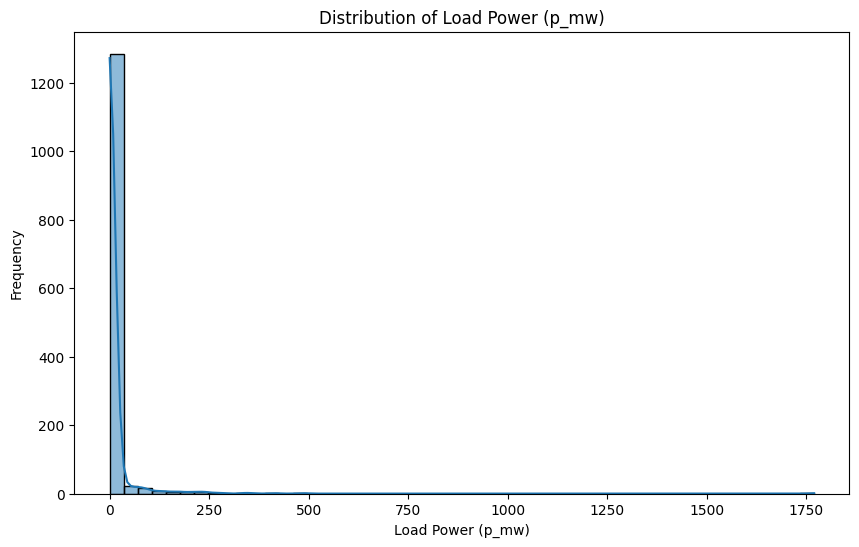

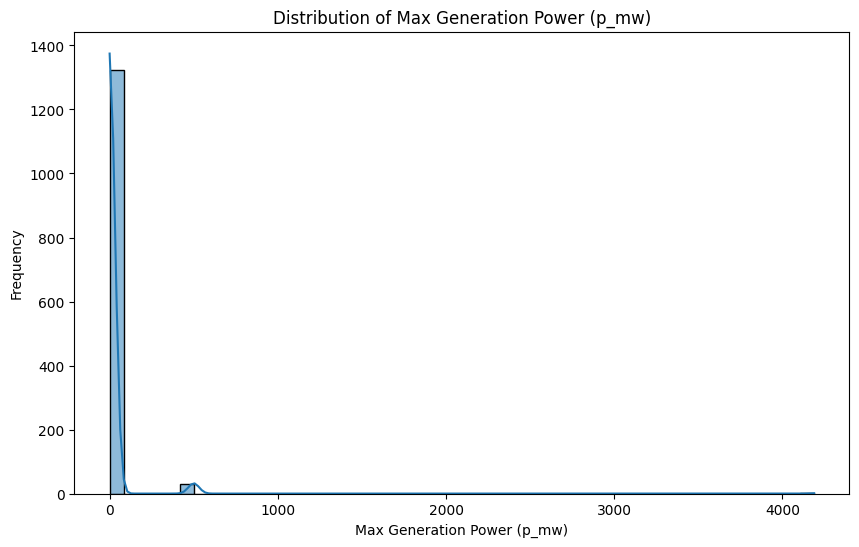

In [38]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.utils.convert import to_networkx
import networkx as nx

# Load network data: node features, edge_features and edge_index
node_features = pd.read_csv('network/node_features.csv', index_col=0, header=0)
node_features = node_features.astype(np.float64).fillna(value=0)
branch_index = pd.read_csv('network/branch_index.csv', index_col=0, header=0)
trafo_index = pd.read_csv('network/trafo_index.csv', index_col=0, header=0)
branch_attr = pd.read_csv('network/branch_attr.csv', index_col=0, header=0)
trafo_attr = pd.read_csv('network/trafo_attr.csv', index_col=0, header=0)

# Display the shapes
print(node_features.shape, branch_index.shape, trafo_index.shape, branch_attr.shape, trafo_attr.shape)

# Convert indices to torch tensors
branch_index = torch.tensor(branch_index.to_numpy().T, dtype=torch.long)
trafo_index = torch.tensor(trafo_index.to_numpy().T, dtype=torch.long)

# Load synthetic 'p_mw' at load buses
p_load_data = pd.read_csv('synthetic_data/p_load_data.csv', index_col=0, header=0)

# Load synthetic 'p_mw' at generator buses
p_gen_data = pd.read_csv('synthetic_data/p_gen_data.csv', index_col=0, header=0)

# Load scaled 'p_mw' at all buses
p_bus_data = pd.read_csv('synthetic_data/p_bus_data.csv', index_col=0, header=0)

# Load max generation power at the slack bus
p_slack_max_data = pd.read_csv('synthetic_data/p_slack_max_data.csv', index_col=0, header=0)

# Define bus arrays
bus = np.arange(node_features.shape[0])

# Load and generation buses
load_bus = pd.read_csv('zones/load_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1
gen_bus = pd.read_csv('zones/re_gen_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1
re_gen_bus = pd.read_csv('zones/wind_bus.csv', index_col=None, header=None).to_numpy().reshape((-1)) - 1

# Ensure load_bus and re_gen_bus are valid indices in node_features
valid_load_indices = [idx for idx in load_bus if idx in node_features.index]
valid_re_gen_indices = [idx for idx in re_gen_bus if idx in node_features.index]

# Summarize loaded data
print(f"Node features shape: {node_features.shape}")
print(f"Branch index shape: {branch_index.shape}")
print(f"Trafo index shape: {trafo_index.shape}")
print(f"Branch attributes shape: {branch_attr.shape}")
print(f"Trafo attributes shape: {trafo_attr.shape}")
print(f"p_load_data shape: {p_load_data.shape}")
print(f"p_gen_data shape: {p_gen_data.shape}")
print(f"p_bus_data shape: {p_bus_data.shape}")

# Visualize distributions of key features
plt.figure(figsize=(10, 6))
sns.histplot(node_features['load_p_mw'], bins=50, kde=True)
plt.title('Distribution of Load Power (p_mw)')
plt.xlabel('Load Power (p_mw)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(node_features['max_gen_p_mw'], bins=50, kde=True)
plt.title('Distribution of Max Generation Power (p_mw)')
plt.xlabel('Max Generation Power (p_mw)')
plt.ylabel('Frequency')
plt.show()

# Store multiple Data() in a list
data_list = []

for i in range(p_load_data.shape[1]):
    # Ensure we use only the relevant portion of p_load_data
    load_values = p_load_data.iloc[:len(valid_load_indices), i].values
    if len(valid_load_indices) != len(load_values):
        raise ValueError(f"Mismatch in lengths: valid_load_indices={len(valid_load_indices)}, load_values={len(load_values)}")
    node_features.loc[valid_load_indices, 'load_p_mw'] = load_values

    # Ensure the correct length of values for re_gen_no mask
    re_gen_values = p_gen_data.iloc[:len(valid_re_gen_indices), i].values
    if len(re_gen_values) != len(valid_re_gen_indices):
        raise ValueError(f"Mismatch in lengths: re_gen_values={len(re_gen_values)}, valid_re_gen_indices={len(valid_re_gen_indices)}")
    node_features.loc[valid_re_gen_indices, 'max_gen_p_mw'] = re_gen_values
    node_features.loc[valid_re_gen_indices, 'min_gen_p_mw'] = re_gen_values

    # Set max_p_mw at the slack bus
    node_features.loc[271, 'max_gen_p_mw'] = p_slack_max_data.iloc[i].values

    # Convert features and targets to tensors
    X = torch.from_numpy(node_features.to_numpy()).float()
    y = torch.from_numpy(p_bus_data.iloc[:, i].to_numpy().reshape((-1))).float()

    # Create HeteroData object
    data = HeteroData()
    data['node'].x = X
    data['node'].y = y

    # Set edge index and attributes
    data['node', 'branch', 'node'].edge_index = branch_index
    data['node', 'branch', 'node'].edge_attr = torch.from_numpy(branch_attr.to_numpy()).float()
    data['node', 'trafo', 'node'].edge_index = trafo_index
    data['node', 'trafo', 'node'].edge_attr = torch.from_numpy(trafo_attr.to_numpy()).float()

    data_list.append(data)

#



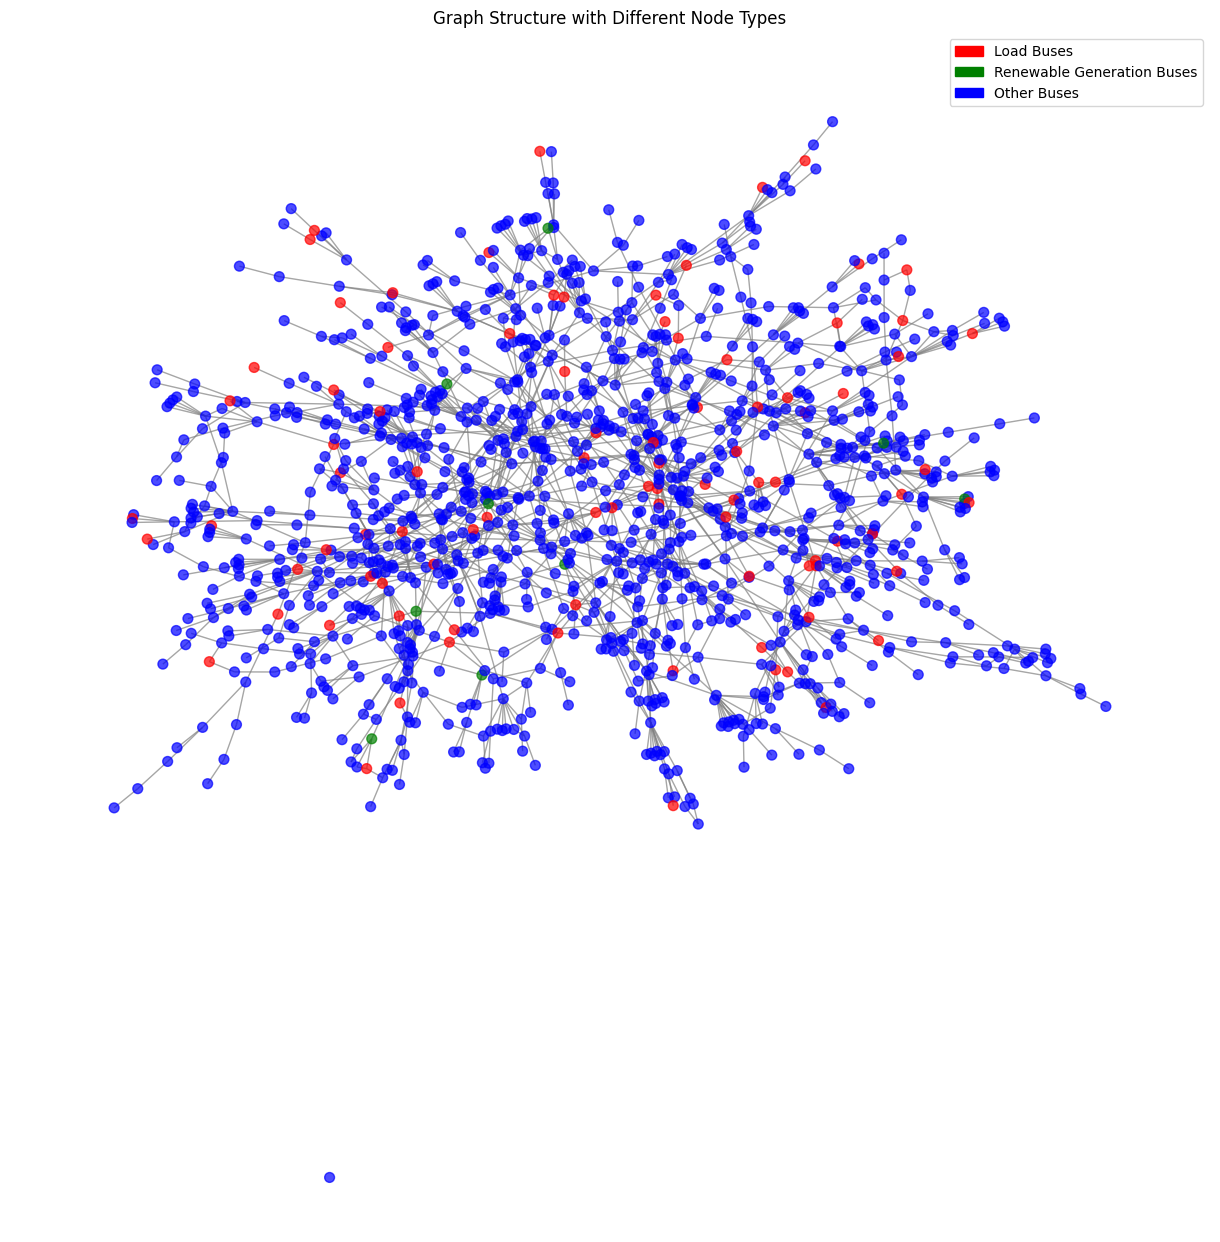

In [39]:
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert HeteroData to NetworkX graph
def hetero_to_networkx(data):
    G = nx.Graph()
    
    # Add nodes with their features
    for i, node_features in enumerate(data['node'].x):
        G.add_node(i, features=node_features)

    # Add edges for branches
    branch_edges = data['node', 'branch', 'node'].edge_index.T
    for edge in branch_edges:
        G.add_edge(edge[0].item(), edge[1].item(), attr='branch')

    # Add edges for transformers
    trafo_edges = data['node', 'trafo', 'node'].edge_index.T
    for edge in trafo_edges:
        G.add_edge(edge[0].item(), edge[1].item(), attr='trafo')
        
    return G

# Use the function to convert the first data example
G = hetero_to_networkx(data_list[0])

# Visualize the graph with color-coded nodes
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Layout for the graph

# Draw nodes with different colors based on their types
node_colors = []
for node in G.nodes():
    if node in valid_load_indices:
        node_colors.append('red')
    elif node in valid_re_gen_indices:
        node_colors.append('green')
    else:
        node_colors.append('blue')

# Draw nodes and edges
nx.draw(G, pos, node_size=50, node_color=node_colors, edge_color='grey', alpha=0.7, with_labels=False)

# Create a legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Load Buses')
green_patch = mpatches.Patch(color='green', label='Renewable Generation Buses')
blue_patch = mpatches.Patch(color='blue', label='Other Buses')
plt.legend(handles=[red_patch, green_patch, blue_patch])

plt.title('Graph Structure with Different Node Types')
plt.show()



Top 10 nodes with highest degree centrality:
Node 134: 0.0096
Node 787: 0.0096
Node 1329: 0.0096
Node 305: 0.0081
Node 355: 0.0081
Node 721: 0.0081
Node 53: 0.0074
Node 181: 0.0074
Node 217: 0.0074
Node 483: 0.0074
Average number of connections: 2.52


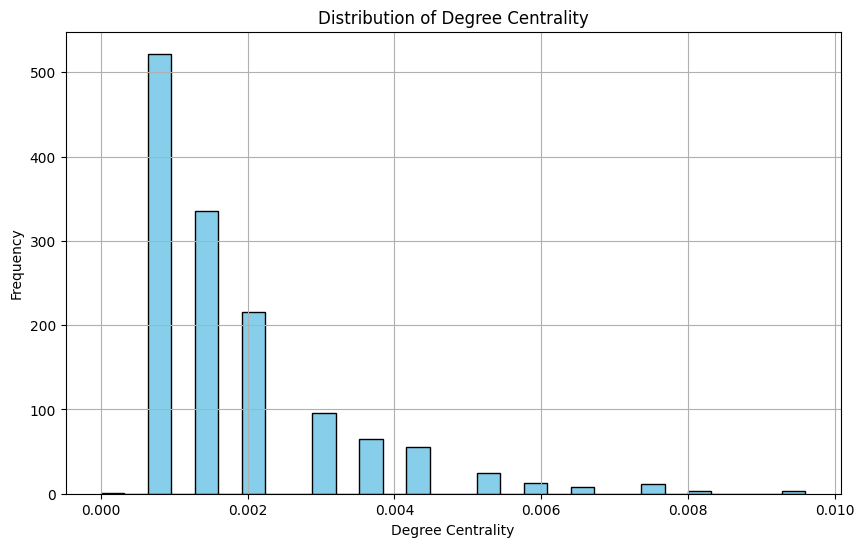

In [40]:
import torch
import networkx as nx
from torch_geometric.utils.convert import to_networkx

# Function to calculate degree centrality and average connections
def calculate_degree_centrality(data):
    G = nx.Graph()
    
    # Add nodes
    for node_type in data.node_types:
        G.add_nodes_from(
            (n, {"node_type": node_type}) for n in range(data[node_type].x.size(0))
        )
    
    # Add edges
    for edge_type in data.edge_types:
        u, v = data[edge_type].edge_index
        u = u.numpy()
        v = v.numpy()
        G.add_edges_from(zip(u, v))

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)
    
    # Calculate average degree (average number of connections)
    average_connections = sum(dict(G.degree()).values()) / float(len(G))

    return degree_centrality, average_connections

# Calculate degree centrality and average connections
degree_centrality, avg_connections = calculate_degree_centrality(data_example)

# Print top 10 nodes with the highest degree centrality
top_10_nodes = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 nodes with highest degree centrality:")
for node, centrality in top_10_nodes:
    print(f"Node {node}: {centrality:.4f}")

# Print average connections
print(f"Average number of connections: {avg_connections:.2f}")

# Plot degree centrality distribution
plt.figure(figsize=(10, 6))
plt.hist(degree_centrality.values(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Degree Centrality')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
